# Wall detection

In [1]:
from fastcore.xtras import Path

from fastai.callback.schedule import lr_find

from fastai.vision.all import * #you need this for a nice ouput from the training loop
# from fastai.vision.augment import aug_transforms, Resize
# from fastai.vision.core import PILImage, PILImageBW, PILMask
# from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
# from fastai.vision.learner import unet_learner

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, RandomSplitter, Normalize

from fastai.torch_core import tensor

from fastai.vision.widgets import *

import torch
from torchvision.models.resnet import resnet34
import numpy as np
import gc
from pdb import set_trace
import matplotlib.pyplot as plt

In [2]:
path = Path("data")
path.ls()

(#3) [Path('data/walllabels'),Path('data/images'),Path('data/wallmasks')]

In [3]:
path_lbl = path/'walllabels'
path_img = path/'images'

# Data

In [4]:
fnames = get_image_files(path_img)
# fnames[:3]

In [5]:
len(fnames)

122

In [6]:
lbl_names = get_image_files(path_lbl)
# lbl_names[:3]

In [7]:
img_f = fnames[0]
img = PILImage.create(img_f)
# img.show(figsize=(10,10))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

In [9]:
mask = PILMask.create(get_y_fn(img_f))
#mask.show(figsize=(10,10), alpha=1)

In [10]:
# tens = tensor(mask)
# tens.unique()
# tens

In [11]:
src_size = np.array(mask.shape[1:])
#src_size,mask.data

In [12]:
codes = ['wall', 'not-wall']; codes

['wall', 'not-wall']

# Datasets

In [13]:
size = src_size//8
print(f"size: {size}")

free = (torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)) / (1024 * 1024)
print(free)
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=4
else:           bs=2
print(f"using bs={bs}, have {free}MB of GPU RAM free")

size: [708]
11016.9375
using bs=4, have 11016.9375MB of GPU RAM free


In [14]:
smaller = tuple(int(x/16) for x in mask.size); smaller

(354, 461)

In [15]:
datablock = DataBlock(blocks=(ImageBlock(cls=PILImage), MaskBlock(codes=codes)),
                      get_items=get_image_files,
                      splitter=RandomSplitter(valid_pct=0.1, seed=42),
                      get_y=get_y_fn,
                      batch_tfms=[Normalize.from_stats(*imagenet_stats)],
                      item_tfms=[Resize(smaller)]) 

In [16]:
dls = datablock.dataloaders(path_img, bs=bs)

/home/gosia/anaconda3/envs/fastai/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630839582/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [17]:
# src = (SegmentationItemList.from_folder(path_img)
#        .split_by_rand_pct(valid_pct=0.1, seed=1)
#        .label_from_func(get_y_fn, classes=codes))

In [18]:
# data = (src.transform(transforms, size=size, tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

In [19]:
# def _plot(i,j,ax):
#     x,y = data.train_ds[1]
#     x.show(ax, y=y)

# plot_multi(_plot, 3, 3, figsize=(8,8))

In [20]:
#dls.show_batch(figsize=(18,18))

# Model

In [21]:
name2id = {v:k for k,v in enumerate(codes)}
wall_code = name2id['wall']

#def acc_camvid(input, target):
#    target = target.squeeze(1)
#    mask = target != void_code
#    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
def acc_wall(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def precision(input, target):
    # remove the channel dimension (?)
    target = target.squeeze(1)
    input = input.argmax(dim=1)
    mask = input == wall_code
    return (input[mask]==target[mask]).float().mean()

def recall(input, target):
    target = target.squeeze(1)
    mask = target == wall_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
    

In [22]:
# test the metrics
# input = tensor([[1,0,0],[1,1,1]],[[0, 1, 1], [0, 0, 0]])
# target = tensor([1, 1, 1], [0, 0, 0])
# print(precision(input[None], target[None][None])) # add batch dimension to input and batch and channel dimension to target
# recall(input[None], target[None][None])

In [23]:
metrics=[acc_wall, precision, recall]
#metrics=acc_wall

In [24]:
# Loss with weights for unbounded classes
tensmask = tensor(mask)
elems, counts = torch.unique(tensmask, return_counts=True)
print(f"Mask pixel counts: {counts}")
sum = torch.sum(counts).item()
weights = (1.0 - counts/sum).cuda()
print(f"Class weights: {weights}")
loss_func = CrossEntropyLossFlat(weight=weights, axis=1)

Mask pixel counts: tensor([ 1069410, 40799583])
Class weights: tensor([0.9745, 0.0255], device='cuda:0')


In [26]:
def cuda_mem_usage():
    max_mem = torch.cuda.max_memory_allocated()
    mem = torch.cuda.memory_allocated()
    print(f"max_mem: {max_mem}, mem: {mem}")

In [27]:
learn = None
gc.collect()
cuda_mem_usage()
print(f"metrics: {metrics}")
learn = unet_learner(dls, resnet34, metrics=metrics, loss_func=loss_func)
cuda_mem_usage()

max_mem: 7835136, mem: 1536
metrics: [<function acc_wall at 0x7f1a502a2ca0>, <function precision at 0x7f1a502a2c10>, <function recall at 0x7f1a502a2dc0>]
max_mem: 32070656, mem: 1536


In [28]:
#learn.summary()

In [29]:
cuda_mem_usage()
#learn.lr_find()

max_mem: 32070656, mem: 1536


In [30]:
lr=7e-5
learn.fine_tune(5)

epoch,train_loss,valid_loss,acc_wall,precision,recall,time
0,0.298162,0.178411,0.962242,0.507908,0.888768,00:14


epoch,train_loss,valid_loss,acc_wall,precision,recall,time
0,0.141768,0.108513,0.928290,0.350183,0.986626,00:12
1,0.095876,0.081841,0.958810,0.506069,0.978005,00:12
2,0.081437,0.089965,0.977247,0.645482,0.962521,00:12
3,0.065440,0.052118,0.973538,0.601570,0.984272,00:11
4,0.052744,0.051973,0.981449,0.683621,0.980121,00:12


In [31]:
learn.save('stage-1')

Path('models/stage-1.pth')

In [ ]:
learn.load('stage-1');

In [ ]:
# learn.destroy()
# learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()
# learn.load('stage-1')

In [32]:
def show_results():
    n_valid = len(dls.valid_ds)
    figsize = (15, n_valid*5)
    fig,axs = plt.subplots(n_valid, 3, figsize=figsize)
    rsz = Resize(smaller)
    for i,(x,y) in enumerate(dls.valid_ds):
        x = rsz(x)
        y = rsz(y)
        x.show(ax=axs[i,0], figsize=(5,5))
        y.show(ax=axs[i,1], figsize=(5,5))
        pred, label, raw = learn.predict(x)        
        #r = recall(pred[None], tensor(y)[None])
        #p = precision(pred[None], tensor(y)[None])
        pred.show(ax=axs[i,2], figsize=(5,5)) #, title=f"recall: {r:.2f}, precision: {p:.2f}")

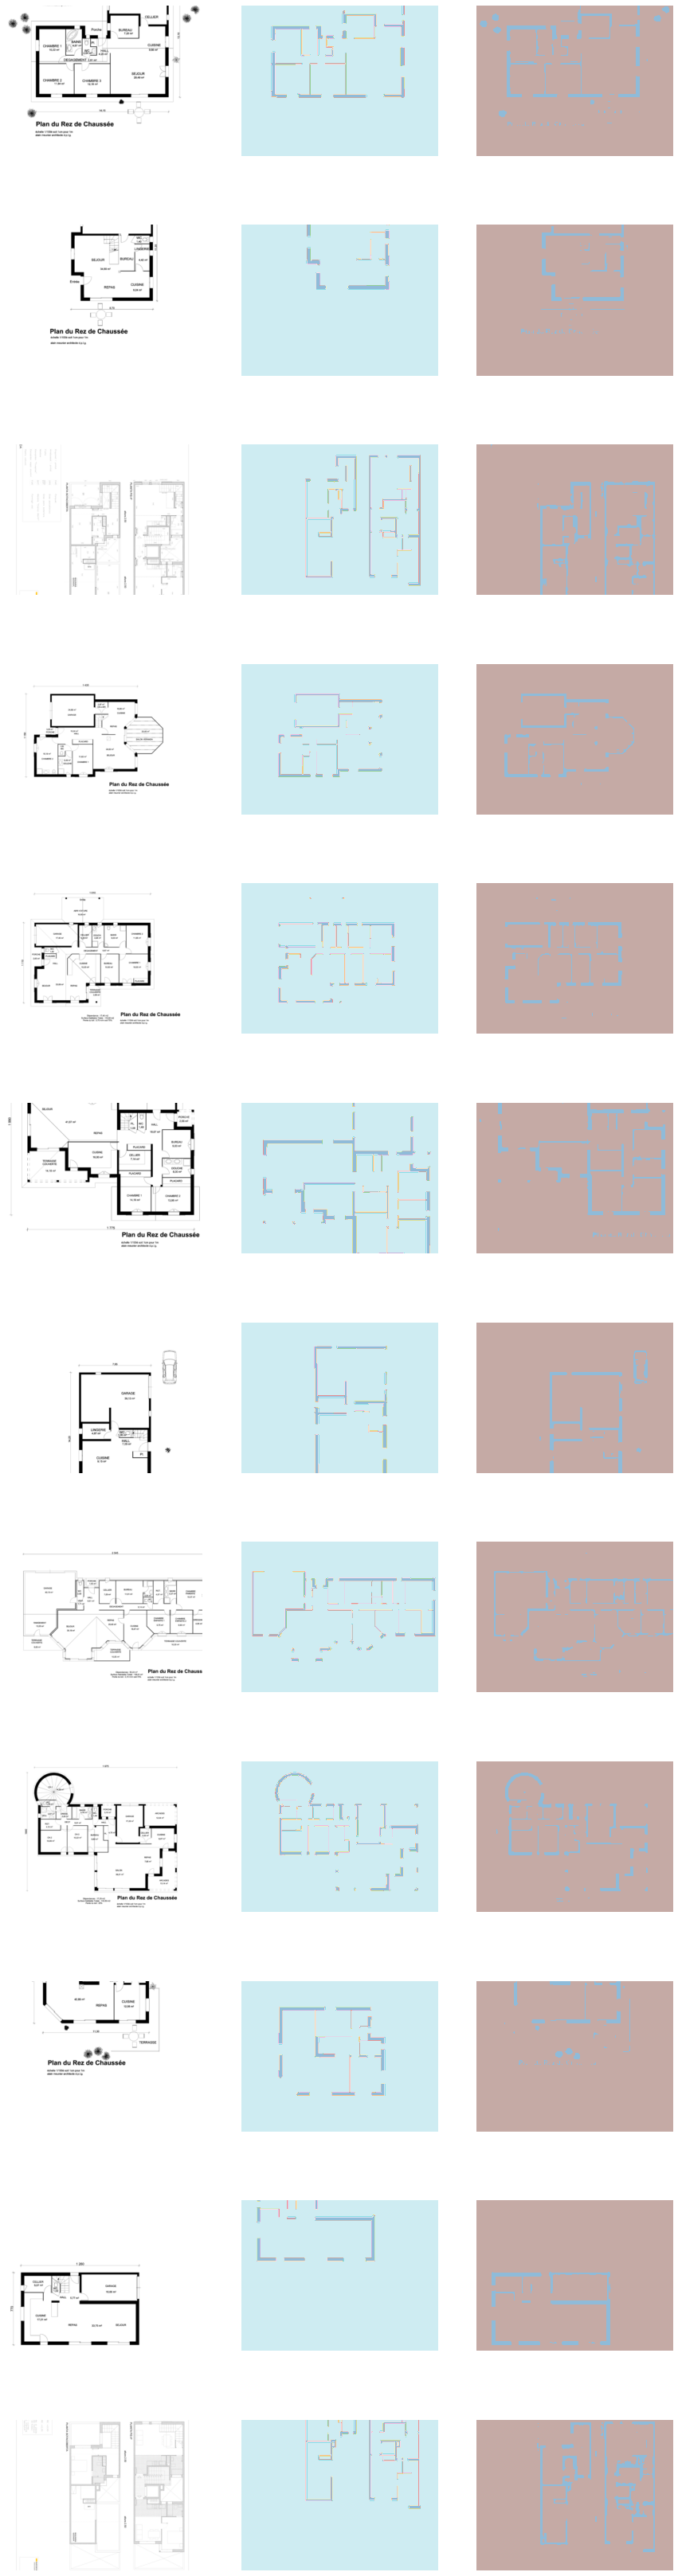

In [33]:
show_results()

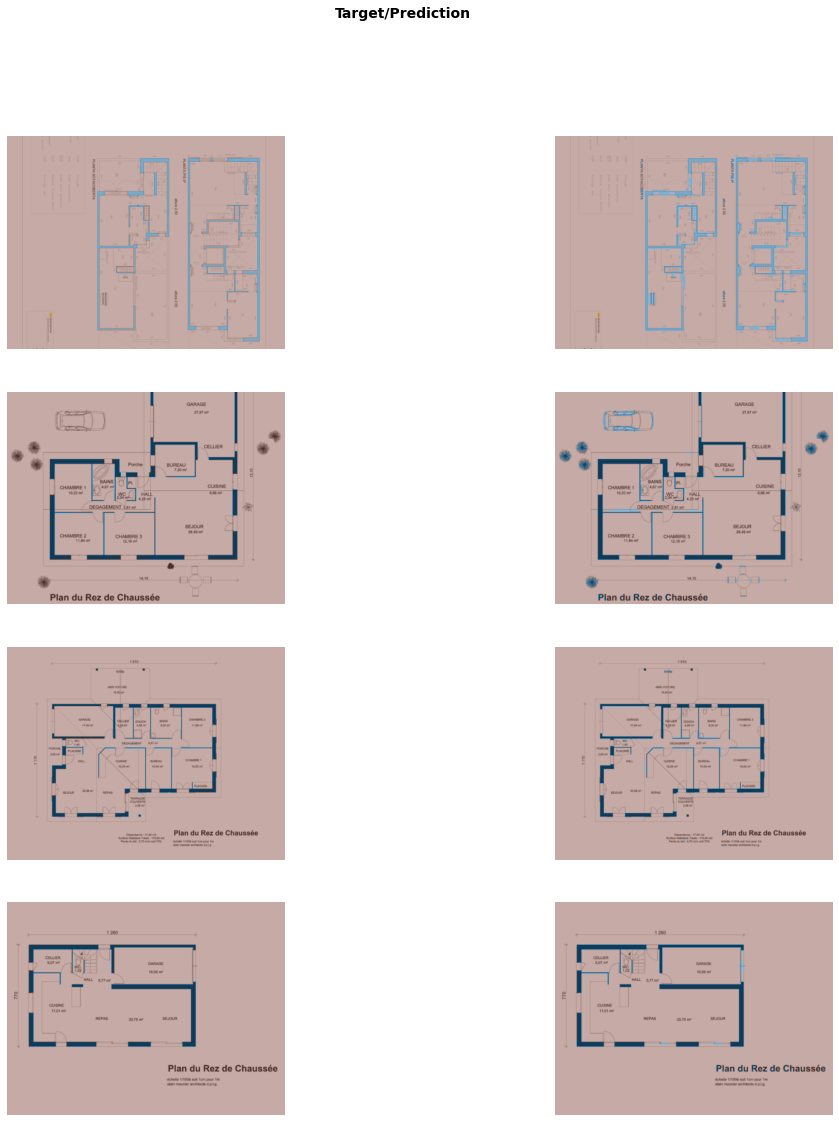

In [34]:
#show_results()
learn.show_results(figsize=(18,18))

# Inference

In [128]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

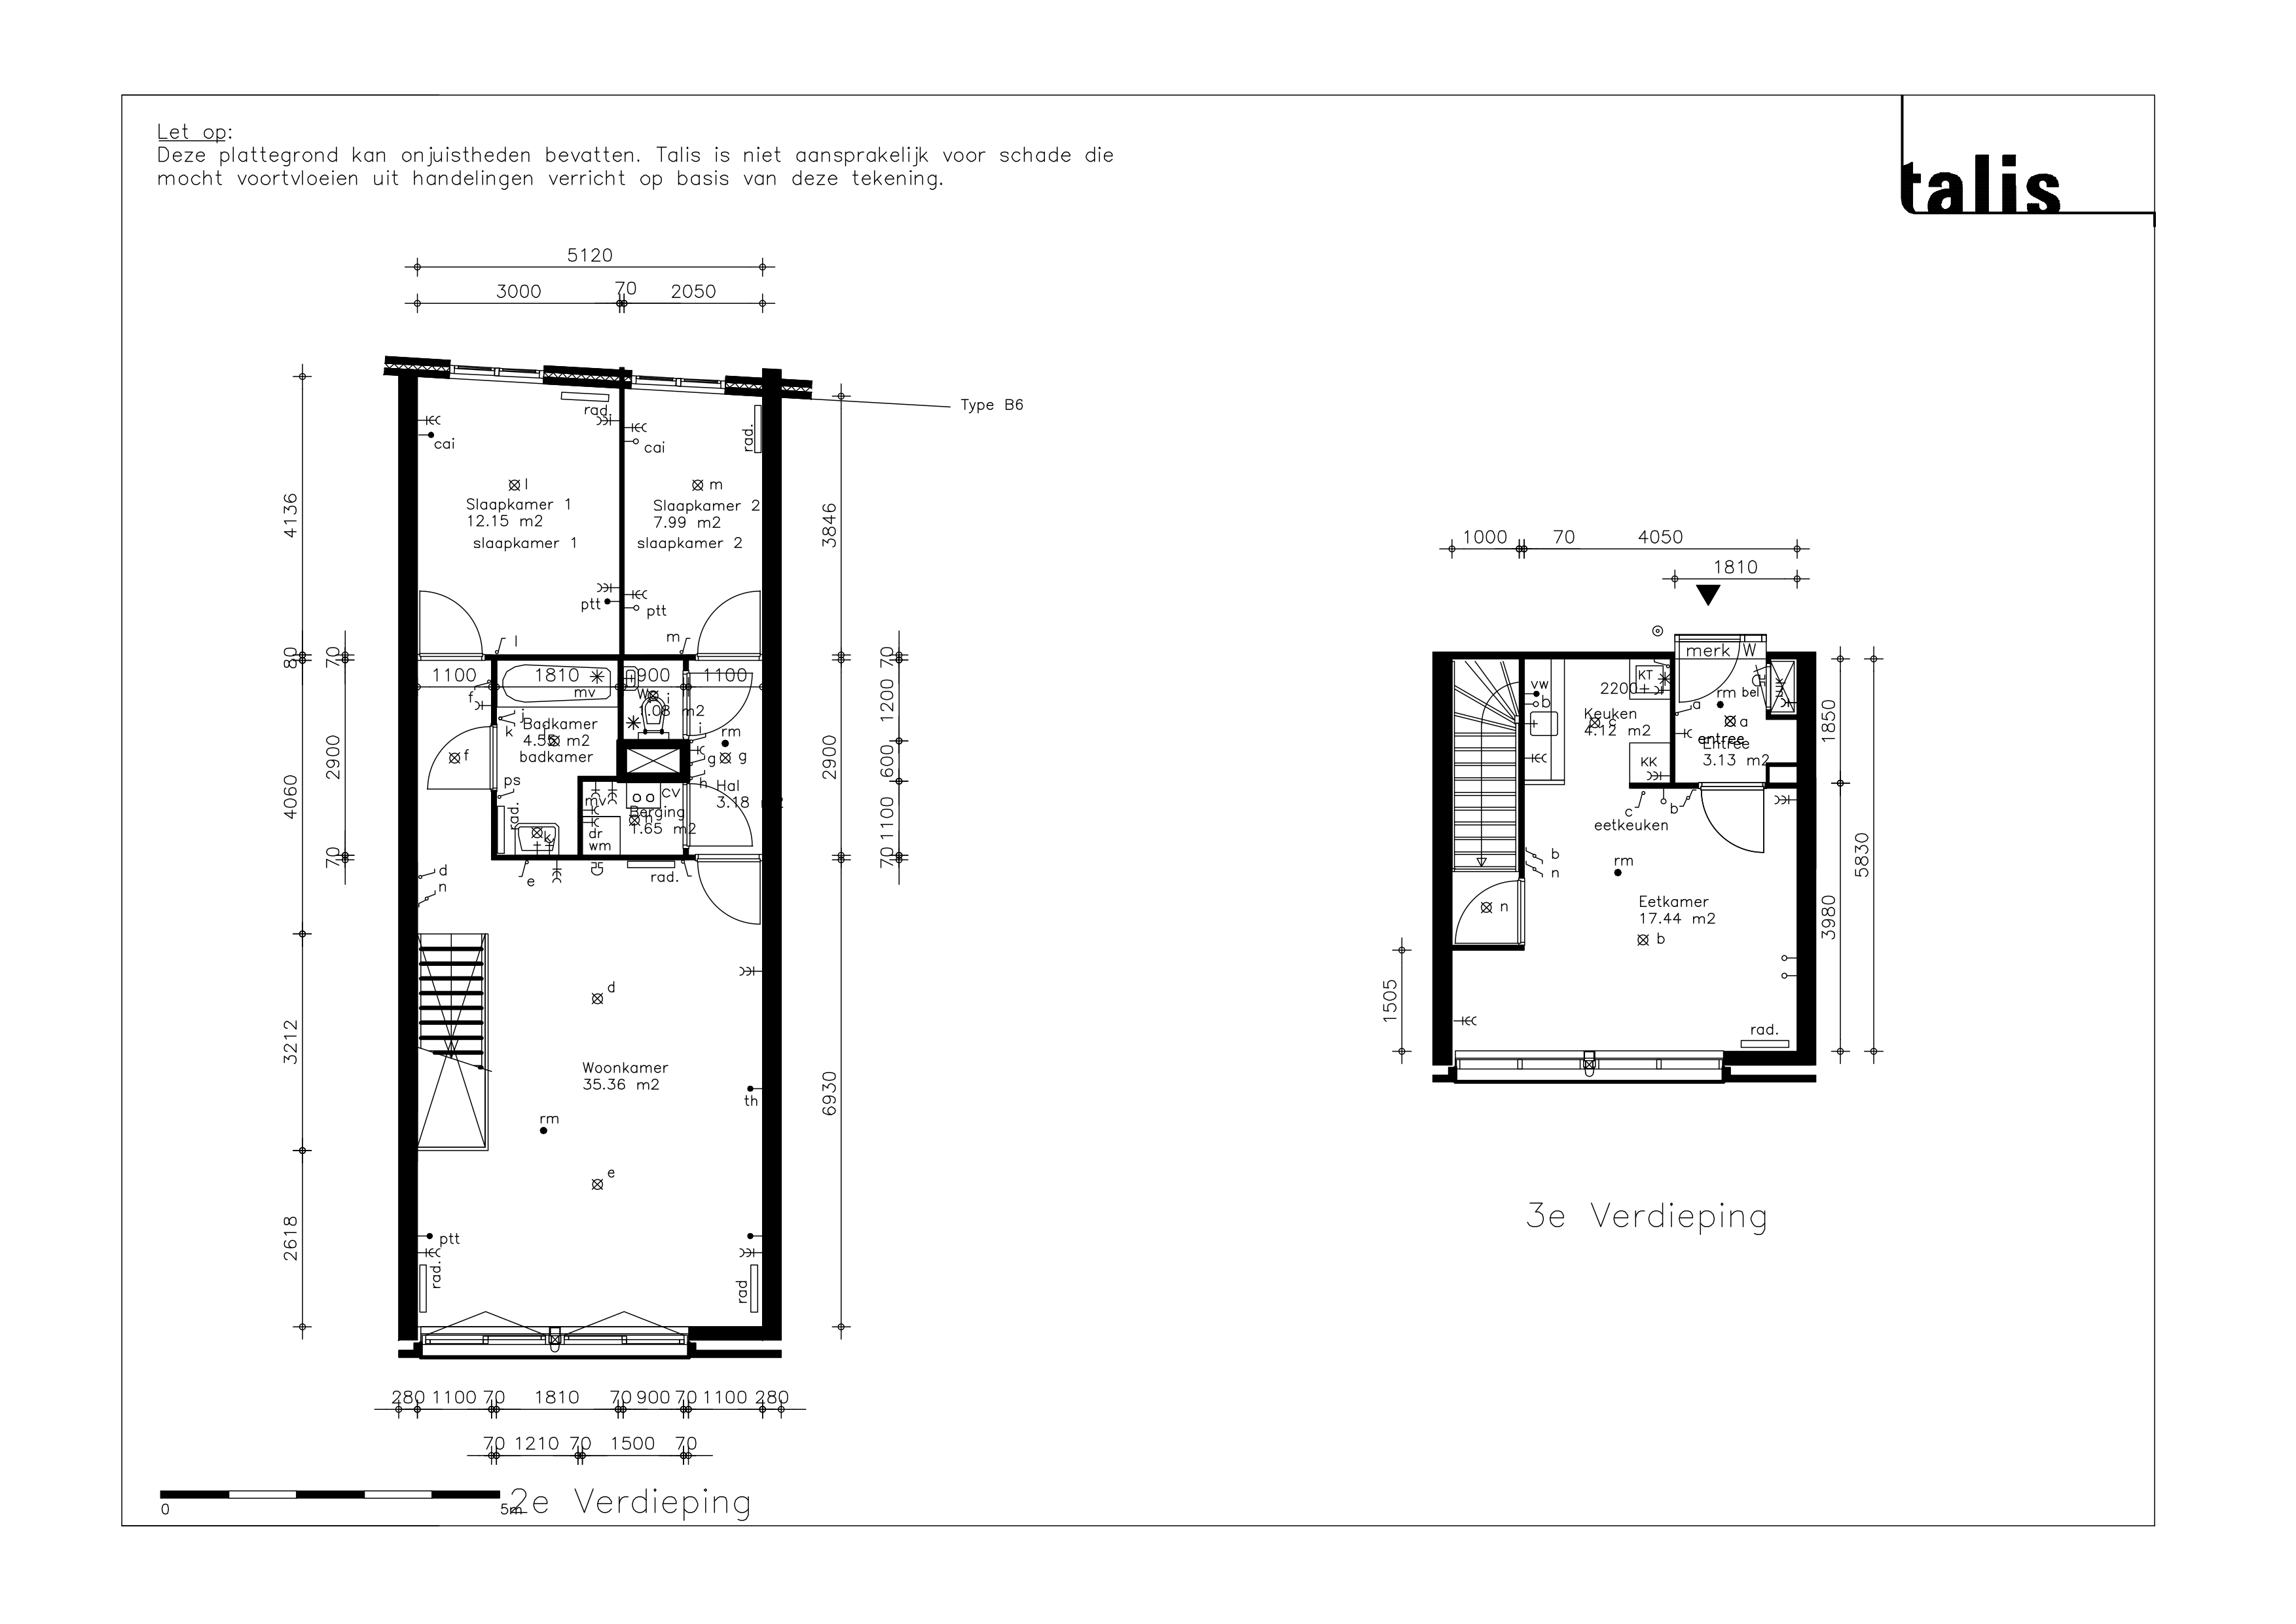

In [140]:
newimg = PILImage.create(btn_upload.data[-1]); newimg

In [141]:
pred, label, raw = learn.predict(newimg)

<AxesSubplot:>

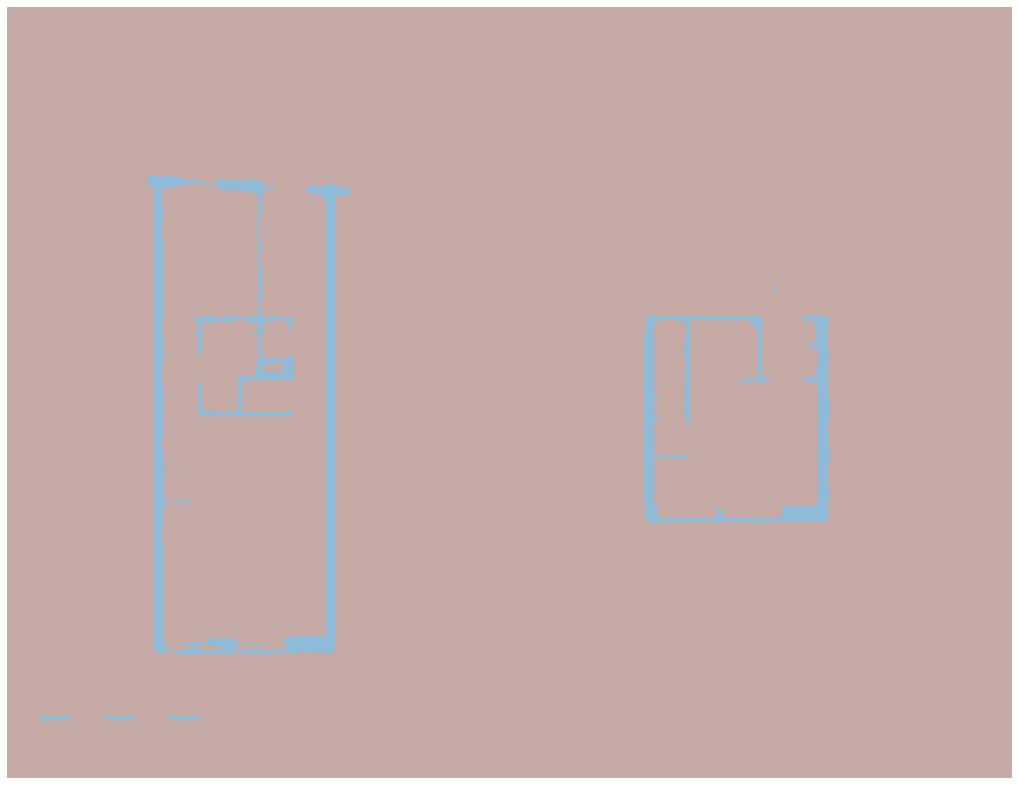

In [142]:
pred.show(figsize=(18,18))